<a href="https://colab.research.google.com/github/vishxl/Book-Price-Prediction/blob/master/Book_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests, zipfile, io
r = requests.get( 'https://github.com/vishxl/Book-Price-Prediction/blob/master/Data.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content)) 
z.extractall()

In [2]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_excel('Participants_Data/Data_Train.xlsx')
test = pd.read_excel('Participants_Data/Data_Test.xlsx')

In [4]:
#combining test and train for cleaning
combined = pd.concat([train, test], sort=False)
combined.reset_index(drop=True, inplace=True)

In [5]:
combined['Reviews'] = combined['Reviews'].str.split(' ').str.get(0).astype(float)
combined['Ratings'] = combined['Ratings'].str.split(' ').str.get(0).str.replace(',','').astype(float)

In [6]:
combined[['Issue_type','Issue_date']] = combined['Edition'].str.split(',– ',expand=True)
combined['Issue_type'] = combined.Issue_type.str.extract(r'(^[a-zA-Z|\s]*)')[0]
combined['Issue_type'].unique()

array(['Paperback', 'Hardcover', 'Mass Market Paperback', 'Sheet music',
       'Flexibound', 'Plastic Comb', 'Loose Leaf', 'Tankobon Softcover',
       'Perfect Paperback', 'Board book', 'Cards', 'Spiral', '',
       'Product Bundle', 'Library Binding', 'Leather Bound'], dtype=object)

In [7]:
#Month & Year
#combined['Issue_year'] = combined.Issue_date.str[-4:].astype(float) ##Alternative Method
combined['Issue_year'] = combined.Issue_date.str.extract('.*(\d{4})', expand = False)
combined['Issue_year'] = combined['Issue_year'].fillna(2004).astype(int) #2004 being the mean

#combined['Issue_year'] = combined['Issue_year'].fillna((combined['Issue_year'].mean()), inplace=True)
#combined['Year_null'] = combined.Issue_year.apply(lambda x: ('not_null' if x!= '' else 'null'))

combined['Book_age'] = 2019 - combined['Issue_year']

combined['Issue_month'] = pd.to_datetime(combined['Issue_date'], errors='coerce').dt.month

#.fillna((combined['Issue_month'].mean()), inplace=True)
#.astype(float)
#combined['Issue_month'] = combined.Issue_month.fillna((combined['Issue_month'].mean()), inplace=True)

In [8]:
#for printing the entire table
"""
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(combined.Issue_year) """

"\nwith pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also\n    print(combined.Issue_year) "

In [9]:
#Genre
combined['Genre'] = combined['Genre'].str.replace(r"\(.*\)","")  #removing '(Books)' from Genre 
combined['Genre'] = combined['Genre'].str.replace(' &',',') #replace '&' with ,
combined['Genre_count'] = combined['Genre'].apply(lambda x: len(x.split(',')))  #Counting Genre

#BookCategory 
combined['BookCategory'] = combined['BookCategory'].str.replace(r"\(.*\)","")  #removing '(Books)' from Genre 
combined['BookCategory'] = combined['BookCategory'].str.replace(' &',',') #replace '&' with ,
combined['BookCategory_count'] = combined['BookCategory'].apply(lambda x: len(x.split(',')))

In [10]:
combined.describe(include = 'all').head(2)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Issue_type,Issue_date,Issue_year,Book_age,Issue_month,Genre_count,BookCategory_count
count,7797,7797,7797,7797.0,7797.0,7797,7797,7797,6237.0,7797,7797,7797.0,7797.0,6808.0,7797.0,7797.0
unique,6787,4372,3882,NaN,NaN,6771,363,11,NaN,16,3332,NaN,NaN,NaN,NaN,NaN


In [11]:
#combined['Rating_Ratio'] = round(combined['Rating_values']/combined['Reviews_values'], 2)
combined['Net_Rating'] = round(combined['Ratings']*combined['Reviews'], 2)

In [12]:
#Authors
author_replacements = {' & ':', ',"0":"other","2":"other",'A. P. J. Abdul Kalam':'A.P.J. Abdul Kalam','APJ Abdul Kalam':'A.P.J. Abdul Kalam','Agrawal P. K.': 'Agrawal P.K','Ajay K Pandey': 'Ajay K. Pandey','Aravinda Anantharaman': 'Aravinda Anatharaman','Arthur Conan Doyle': 'Sir Arthur Conan Doyle','B A Paris': 'B. A. Paris','E L James': 'E. L. James','E.L. James':'E. L. James','Eliyahu M Goldratt': 'Eliyahu M. Goldratt','Ernest Hemingway': 'Ernest Hemmingway','Frank Miler': 'Frank Miller','Fyodor Dostoevsky': 'Fyodor Dostoyevsky','George R R Martin': 'George R. R. Martin','George R.R. Martin':'George R. R. Martin','H. G. Wells': 'H.G. Wells','Johann Wolfgang Von Goethe': 'Johann Wolfgang von Goethe','John Le Carré': 'John le Carré','Judith McNaught': 'Judith Mcnaught','Keith Giffen': 'Kieth Giffen','Ken Hultgen': 'Ken Hultgren','Kentaro Miura': 'Kenturo Miura','Kohei Horikoshi': 'Kouhei Horikoshi','M.K Gandhi': 'M.K. Gandhi','Matthew K Manning': 'Matthew Manning','Michael Crichton': 'Micheal Crichton','N.K Aggarwala': 'N.K. Aggarwala','Oxford University Press (India)': 'Oxford University Press India','P D James': 'P. D. James','Paramahansa Yogananda': 'Paramhansa Yogananda','R K Laxman': 'R. K. Laxman','R.K. Laxman': 'R. K. Laxman','R. M. Lala': 'R.M. Lala','Raina Telgemaeier': 'Raina Telgemeier','Rajaraman': 'Rajaraman V','Rajiv M. Vijayakar': 'Rajiv Vijayakar','Ramachandra Guha': 'Ramchandra Guha','Rene Goscinny': 'René Goscinny','Richard P Feynman': 'Richard P. Feynman','S Giridhar': 'S. Giridhar','S Hussain Zaidi': 'S. Hussain Zaidi','S. A. Chakraborty': 'S. Chakraborty','Santosh Kumar K': 'Santosh Kumar K.',"S.C. Gupta" : "S. C. Gupta",'Shiv Prasad Koirala': 'Shivprasad Koirala','Shivaprasad Koirala': 'Shivprasad Koirala','Simone De Beauvoir': 'Simone de Beauvoir','Sir Arthur Conan Doyle': 'Arthur Conan Doyle',"Terry O' Brien": "Terry O'Brien",'Thich Nhat Hahn': 'Thich Nhat Hanh','Trinity College Lond': 'Trinity College London',"Trinity College London Press" : "Trinity College London",'Ursula K. Le Guin': 'Ursula Le Guin','Willard A Palmer': 'Willard A. Palmer','Willard Palmer': 'Willard A. Palmer','William Strunk Jr': 'William Strunk Jr.','Yashavant Kanetakr': 'Yashavant Kanetkar','Yashavant P. Kanetkar': 'Yashavant Kanetkar','Yashwant Kanetkar': 'Yashavant Kanetkar','et al': 'et al.',' et al': 'et al.','Peter Clutterbuck': ' Peter Clutterbuck','Scholastic': 'Scholastic ','Ullekh N. P.': 'Ullekh N.P.','Shalini Jain': 'Dr. Shalini Jain','Kevin Mitnick': 'Kevin D. Mitnick'}
combined['Author'] = combined['Author'].replace(author_replacements,regex=True)
combined['Author_count'] = combined['Author'].apply(lambda x: len(x.split(',')))

In [13]:
#Dropping Columns
#combined.drop(['Author_num'], axis=1, inplace=True)

In [14]:
#number of books by an author
#No_books_by_author = combined['Author'].value_counts()

In [15]:
#Average Rating of an Authors, books
combined.columns

Index(['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
       'BookCategory', 'Price', 'Issue_type', 'Issue_date', 'Issue_year',
       'Book_age', 'Issue_month', 'Genre_count', 'BookCategory_count',
       'Net_Rating', 'Author_count'],
      dtype='object')

In [16]:
combined['Review_Impact']= combined['Reviews']*combined['Book_age']

In [17]:
#combined = pd.get_dummies(combined, drop_first=True)

In [18]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
combined[['Issue_type','Issue_month']] = combined[['Issue_type','Issue_month']].apply(enc.fit_transform)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
t_vectorizer = CountVectorizer(max_features=10, lowercase=True)
t_vector = t_vectorizer.fit_transform(combined['Title']).toarray()
df_title = pd.DataFrame(data=t_vector,
                        columns=t_vectorizer.get_feature_names())

In [20]:
bc_vectorizer = CountVectorizer(lowercase=True, tokenizer=lambda x: x.split(', '))
book_cat_vector = bc_vectorizer.fit_transform(combined['BookCategory']).toarray()
df_book_cat = pd.DataFrame(data=book_cat_vector,
                      columns=bc_vectorizer.get_feature_names())

In [21]:
genre_vectorizer = CountVectorizer(max_features=10,
                                   lowercase=True, tokenizer=lambda x: x.split(', '))
genre_vector = genre_vectorizer.fit_transform(combined['Genre']).toarray()
df_genre = pd.DataFrame(data=genre_vector,
                        columns=genre_vectorizer.get_feature_names())

In [22]:
author_vectorizer = CountVectorizer(max_features=10, lowercase=True,
                                    tokenizer=lambda x: x.split(', '))
author_vector = author_vectorizer.fit_transform(combined['Author']).toarray()
df_author = pd.DataFrame(data=author_vector,
                         columns=author_vectorizer.get_feature_names())

In [23]:
synopsis_vectorizer = CountVectorizer(max_features=10,
                                      stop_words='english', 
                                      strip_accents='ascii', 
                                      lowercase=True)
synopsis_vector = synopsis_vectorizer.fit_transform(combined['Synopsis']).toarray()
df_syn = pd.DataFrame(data=synopsis_vector,
                           columns=synopsis_vectorizer.get_feature_names())

In [24]:
combined.columns

Index(['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
       'BookCategory', 'Price', 'Issue_type', 'Issue_date', 'Issue_year',
       'Book_age', 'Issue_month', 'Genre_count', 'BookCategory_count',
       'Net_Rating', 'Author_count', 'Review_Impact'],
      dtype='object')

In [25]:
final = combined[['Price','Reviews', 'Ratings', 'Issue_type','Issue_month', 'Genre_count',
       'BookCategory_count', 'Net_Rating','Review_Impact', 'Author_count', 
       'Book_age']]

In [27]:
final = pd.concat([
    final,# dummy encoded features
    df_title,
    df_book_cat,
    df_genre,
    df_author,
    df_syn,
    ], axis=1)
final.reset_index(drop=True, inplace=True)

In [28]:
final.head()

,Price,Reviews,Ratings,Issue_type,Issue_month,Genre_count,BookCategory_count,Net_Rating,Review_Impact,Author_count,Book_age,and,book,for,guide,how,in,of,the,to,with,action,adventure,arts,biographies,comics,computing,crime,diaries,digital media,film,humour,internet,language,linguistics,mangas,mystery,photography,politics,romance,sports,thriller,true accounts,writing,action,adventure,autobiographies,biographies,comics,contemporary fiction,crime,mystery,romance,thriller,agatha christie,albert uderzo,bill watterson,dk,herge,james patterson,john grisham,ladybird,nora roberts,p.g. wodehouse,author,best,book,life,love,man,new,story,time,world
0,220.00,4.0,8.0,9,2,2,2,32.0,12.0,1,3,0,0,0,0,0,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1
1,202.93,3.9,14.0,9,10,2,3,54.6,27.3,1,7,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,0,1,0,1,1
2,299.00,4.8,6.0,9,1,1,1,28.8,177.6,1,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,1,2
3,180.00,4.1,13.0,9,9,1,3,53.3,8.2,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,965.62,5.0,1.0,4,9,1,3,5.0,65.0,1,13,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,1


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


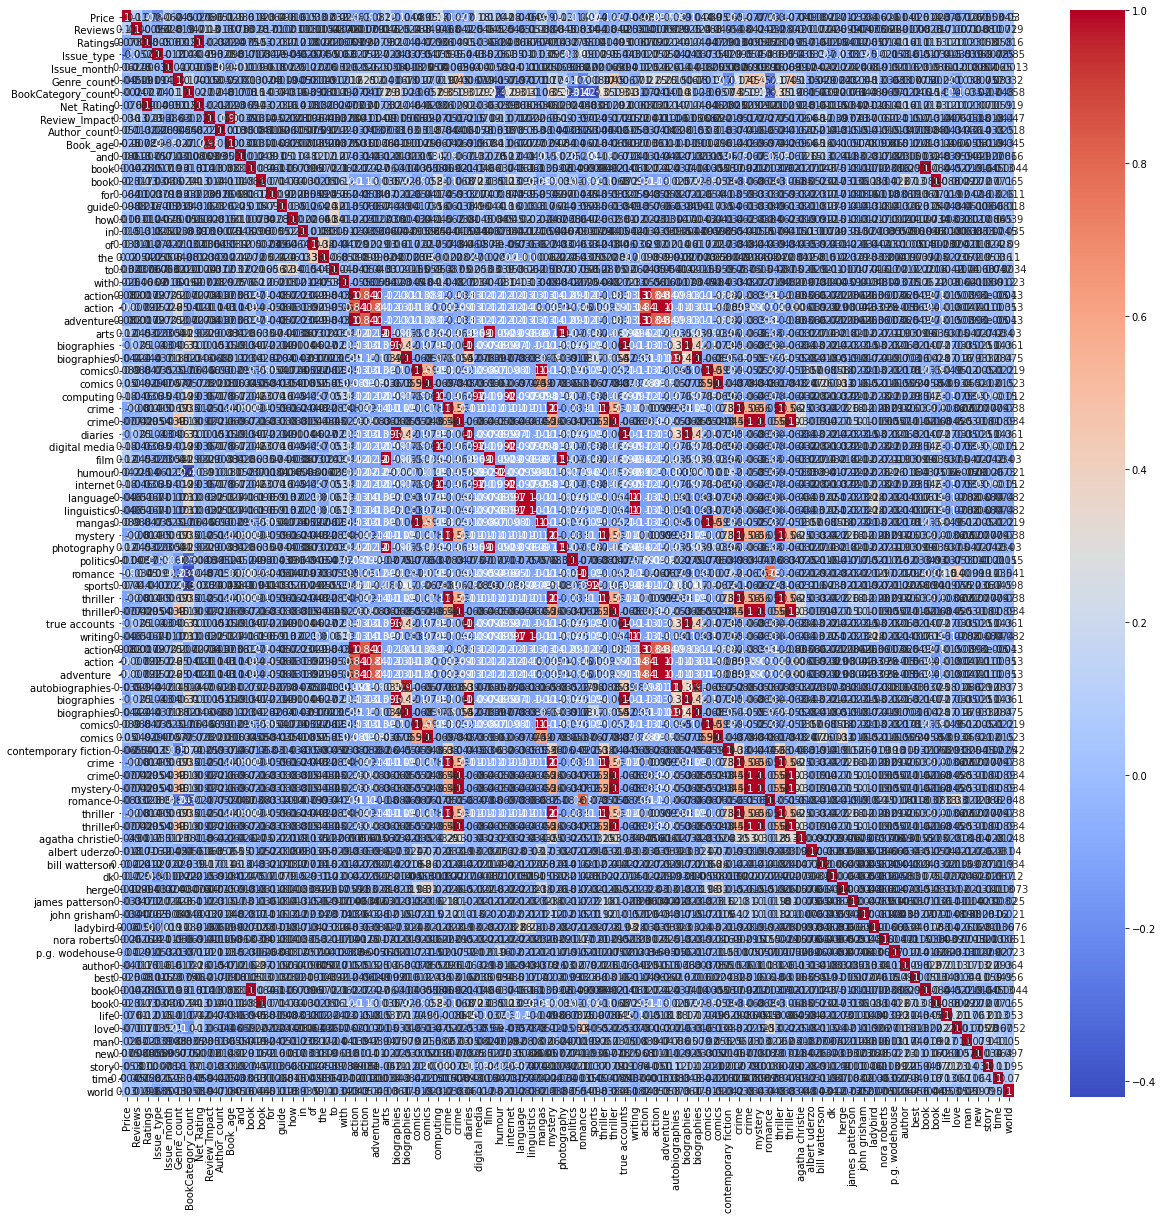

In [30]:
correlation_mat = final.corr()
top_corr_features = correlation_mat.index
plt.figure(figsize=(20,20))
g= sns.heatmap(final[top_corr_features].corr(),annot=True,cmap="coolwarm")

In [31]:
#Splitting Train, Test

X_full = final.iloc[:,1:]
X = X_full.iloc[:6237,1:]
y = final.iloc[:6237,0]
X_eval = X_full.iloc[6237:,1:]
print(X_full.shape, X.shape, y.shape, X_eval.shape)

(7797, 73) (6237, 72) (6237,) (1560, 72)


In [32]:
###Feature Importance
from sklearn.ensemble import ExtraTreesRegressor
model=ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [33]:
print(model.feature_importances_) 

[4.19543351e-02 1.07729464e-01 6.67339953e-02 3.87997138e-02
 7.78227134e-03 4.38893455e-02 6.13686702e-02 1.65797913e-02
 5.98885031e-02 2.58049534e-02 5.33487198e-03 1.31648512e-02
 1.16396106e-02 3.53798296e-03 1.75127000e-02 2.02494111e-02
 3.20424380e-02 1.36125932e-02 8.39180564e-03 1.01576894e-03
 1.19082717e-03 5.82345328e-03 7.63798040e-04 1.10584911e-02
 1.31577184e-02 3.90641679e-04 7.58509493e-04 1.15656730e-02
 5.83013946e-03 7.48447363e-03 1.05734803e-02 9.74778746e-04
 7.68738373e-04 1.27683829e-02 3.98897440e-04 6.59300689e-03
 5.71214448e-03 7.63432223e-04 1.07420900e-02 4.60410591e-04
 5.68820429e-04 8.69688195e-04 1.84793816e-03 2.24680785e-03
 1.43134478e-03 2.84436063e-03 1.92088615e-02 1.36327640e-03
 2.82455655e-04 2.34451959e-04 1.33384371e-02 3.22985715e-04
 1.99446500e-04 2.51467024e-04 2.69231162e-04 2.05597949e-03
 3.96200067e-04 4.82866273e-04 7.02286191e-05 3.33972517e-03
 5.54124982e-05 8.75087664e-04 1.35543710e-02 1.68136150e-02
 2.90444848e-02 2.054373

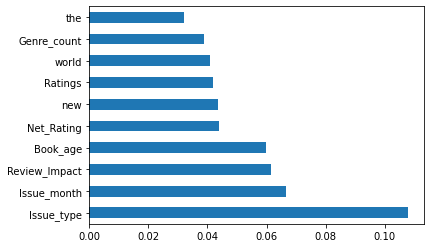

In [34]:
#plot graph of feature importance for better visualization
feat_importances = pd.Series(model.feature_importances_,index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [35]:
#train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

In [36]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [37]:
#rf.fit(X_train,y_train)
#preds = rf.predict(X = X_test)

In [38]:
n_estimators= [int(x) for x in np.linspace(start = 100,stop = 1200, num=12)] 
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num =6)]
min_samples_split = [2,5,10,15,100]
min_samples_leaf = [1,2,5,10]
bootstrap = [True, False]

In [39]:
from sklearn.model_selection import RandomizedSearchCV

In [40]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [41]:
rf = RandomForestRegressor()

In [42]:
model_tuned = RandomizedSearchCV(estimator = rf, 
                                 param_distributions = random_grid, 
                                 scoring='neg_mean_squared_error', 
                                 n_iter = 10, 
                                 cv = 5, 
                                 verbose=2, 
                                 random_state=42, 
                                 n_jobs = 2)

In [43]:
model_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  5.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [44]:
#prediction
predictions = model_tuned.predict(X_test)
X_eval.shape

(1560, 72)

In [45]:
eval = model_tuned.predict(X_eval)

In [46]:
eval

array([ 333.78879458, 1265.91292667,  408.1688996 , ...,  589.97061691,
        392.79743475,  556.46479797])

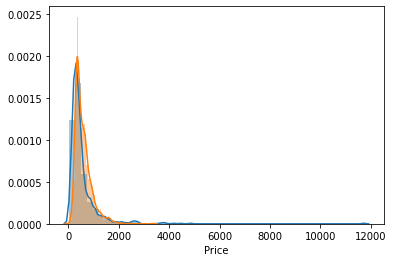

In [47]:
sns.distplot(y_test)
sns.distplot(eval)

In [48]:
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

0.21342096388075882

In [49]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error( y_test, predictions ))

0.6797636668701551

In [50]:
submission = pd.DataFrame() 
submission['Price'] = eval

submission.head()

,Price
0,333.788795
1,1265.912927
2,408.168900
3,573.880306
4,511.682949


In [51]:
from google.colab import files
submission.to_csv('Submission.csv') 
files.download('Submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>